In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
 
#1 加载数据集，把对输入和结果分开
train = pd.read_csv('train.csv')
images_train = train.iloc[:,1:].values
labels_train = train.iloc[:,0].values
 
test = pd.read_csv('test.csv')
images_test = test.iloc[:,:].values
 
#2 对输入进行处理
images_train = images_train.astype(np.float)
images_train = np.multiply(images_train,1.0/255)
images_test = images_test.astype(np.float)
images_test = np.multiply(images_test,1.0/255)
 
images_size = images_train.shape[1]
 
images_width = images_height = np.ceil(np.sqrt(images_size)).astype(np.uint8)
 
#3 对结果进行处理
labels_count = np.unique(labels_train).shape[0]
 
#进行one-hot编码
def dense_to_ont_hot(labels_dense,num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels,num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
 
labels = dense_to_ont_hot(labels_train,labels_count)
labels = labels.astype(np.uint8)
 
#4 对训练集进行分批
batch_size = 64
n_batch = int(len(images_train)/batch_size)
 
#5 创建一个简单的神经网络用来对图片进行识别
x = tf.placeholder('float',shape=[None,images_size])
y = tf.placeholder('float',shape=[None,labels_count])
 
weights = tf.Variable(tf.zeros([784,10]))
biases = tf.Variable(tf.zeros([10]))
result = tf.matmul(x, weights) + biases
predictions = tf.nn.softmax(result)
 
#6 创建损失函数，以交叉熵的平均值为衡量
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=predictions))
 
#7 用梯度下降法优化参数
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
 
#8 初始化变量
init = tf.global_variables_initializer()
 
#9 计算预测值
with tf.Session() as sess:
    #初始化
    sess.run(init)
    #循环50轮
    for epoch in range(50):
        for batch in range(n_batch-1):
            batch_x = images_train[batch*batch_size:(batch+1)*batch_size] 
            batch_y = labels[batch*batch_size:(batch+1)*batch_size]
            #进行训练
            sess.run(train_step,feed_dict={x:batch_x,y:batch_y})
        batch_x = images_train[n_batch*batch_size:]
        batch_y = labels[n_batch*batch_size:]
        sess.run(train_step,feed_dict={x:batch_x,y:batch_y})
    #计算预测
    myPrediction = sess.run(predictions,feed_dict={x:images_test})
 
label_test = np.argmax(myPrediction,axis=1)
pd.DataFrame(label_test).to_csv('simpleNN1.csv') 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten,MaxPool2D,Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
import itertools

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [3]:
batch_size = 256 # 在计算力允许的情况下，batch_size越大越好
nb_classes = 10
nb_epoch = 30

In [4]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(42000, 28, 28, 1)
(28000, 28, 28, 1)
Train Sample: 42000
Test Sample: 28000


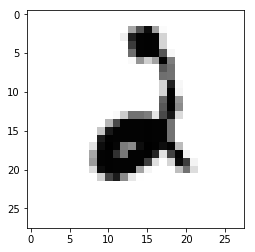

In [5]:
X_train=train_data.drop("label", axis=1)
Y_train=train_data.label
del train_data
# 改变维度：第一个参数是图片数量，后三个参数是每个图片的维度
X_train = X_train.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)
print(X_train.shape)
print(test_data.shape)
print("Train Sample:",X_train.shape[0])
print("Test Sample:",test_data.shape[0])
# 归一化：将数据进行归一化到0-1 因为图像数据最大是255
X_train=X_train/255.0
test_data=test_data/255.0
# 将类别向量(从0到nb_classes的整数向量)映射为二值类别矩阵
Y_train = to_categorical(Y_train, num_classes = nb_classes)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.1)
plt.imshow(X_train[0][:,:,0], cmap="Greys")
plt.show()

In [6]:
'''建立模型'''
model = Sequential()
# filters：卷积核的数目（即输出的维度）
# kernel_size：卷积核的宽度和长度。如为单个整数，则表示在各个空间维度的相同长度。
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [7]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# 计算依赖于数据的变换所需要的统计信息(均值方差等),
# 只有使用featurewise_center，featurewise_std_normalization或zca_whitening时需要此函数。
# datagen.fit(X_train)

In [8]:
'''学习率的设置'''
# 当评价指标monitor不在提升时，减少学习率
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


In [9]:
'''编译和训练模型'''
optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# 使用多类的对数损失categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# history=model.fit(X_train,Y_train,
#           batch_size=batch_size,
#           epochs=nb_epoch,
#           verbose=2,
#           validation_data=(X_val,Y_val))


# ImageDataGenerator需要和fir_generator配合，才能实时进行数据扩增
# 当生成器返回steps_per_epoch次数据时计一个epoch结束，执行下一个epoch
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs =nb_epoch, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size+1,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
 - 90s - loss: 0.8923 - acc: 0.7049 - val_loss: 0.1366 - val_acc: 0.9579
Epoch 2/30
 - 88s - loss: 0.2898 - acc: 0.9121 - val_loss: 0.1053 - val_acc: 0.9679
Epoch 3/30
 - 89s - loss: 0.1744 - acc: 0.9488 - val_loss: 0.0780 - val_acc: 0.9743
Epoch 4/30
 - 95s - loss: 0.1321 - acc: 0.9604 - val_loss: 0.0455 - val_acc: 0.9852
Epoch 5/30
 - 97s - loss: 0.1080 - acc: 0.9672 - val_loss: 0.0348 - val_acc: 0.9879
Epoch 6/30
 - 91s - loss: 0.0953 - acc: 0.9723 - val_loss: 0.0348 - val_acc: 0.9902
Epoch 7/30
 - 95s - loss: 0.0815 - acc: 0.9758 - val_loss: 0.0334 - val_acc: 0.9900
Epoch 8/30
 - 95s - loss: 0.0721 - acc: 0.9784 - val_loss: 0.0299 - val_acc: 0.9902
Epoch 9/30
 - 89s - loss: 0.0672 - acc: 0.9794 - val_loss: 0.0301 - val_acc: 0.9914
Epoch 10/30
 - 94s - loss: 0.0665 - acc: 0.9812 - val_loss: 0.0228 - val_acc: 0.9929
Epoch 11/30
 - 102s - loss: 0.0595 - acc: 0.9819 - val_loss: 0.0219 - val_acc: 0.9931
Epoch 12/30
 - 92s - loss: 0.0590 - acc: 0.9824 - val_loss: 0.0251 - val_

In [10]:
'''评估模型'''
score = model.evaluate(X_val, Y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.01912602308655464
Val accuracy: 0.995


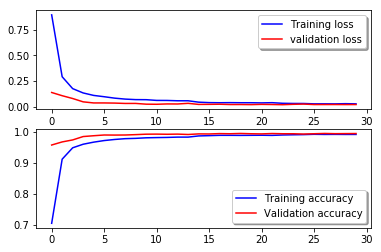

In [11]:
'''绘制学习曲线'''
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
plt.show()


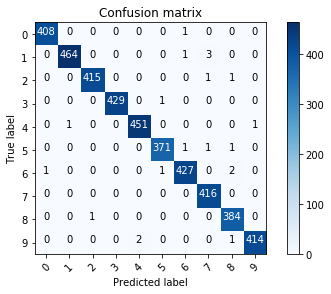

In [12]:
'''混淆矩阵'''
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="Blues"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 是否进行标准化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 根据验证集标签的真实值和预测值计算混淆矩阵（confusion_matrix）
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, classes = range(10))


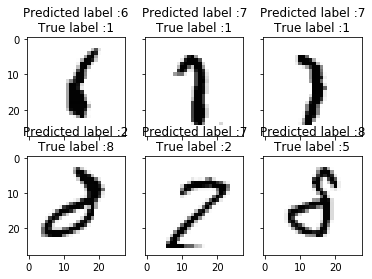

In [13]:
'''查看最显著的错误'''
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)),cmap="Greys")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

errors = (Y_pred_classes - Y_true != 0)  # 矩阵相减得到误差集（?*1）
# 使用布尔索引
Y_pred_classes_errors = Y_pred_classes[errors]  # 误差集的预测标签Y（?*1）
Y_pred_errors = Y_pred[errors]  # 误差集的预测序列（?*10）
Y_true_errors = Y_true[errors]  # 误差集的真实标签Y（?*1）
X_val_errors = X_val[errors]  # 误差集的特征X，即数字图片（?*28*28*1）

# 误差集中对错误标签的预测概率
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
# 误差集中对真实标签的预测概率，np.diagonal是返回对角线的元素
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
# 排序并返回的是数组值从小到大的索引值
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-6:]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


In [15]:
'''预测测试集'''
print('Begin to predict for testing data ...')
results = model.predict(test_data)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submit.csv",index=False)

Begin to predict for testing data ...
